# **Project Final Report**

## **Introduction**

**Question**: Can we use age, experience, and gender to predict the number of played hours a player will contribute to the PLAICraft server?

This study's main inquiry is whether gender, age, and experience can accurately predict how many hours a player will spend on the PLAICraft server. Designing user-centric experiences has become more and more dependent on an understanding of player engagement as online gaming platforms gain popularity. PLAICraft is a community-driven server that tracks gender, age, and skill level in addition to playing hours to provide information on player behavior. This experiment investigates if these demographic and experiential criteria may predict a player's hours of server contribution.

The Player.csv dataset, which includes comprehensive records of players, including characteristics like age group, previous Minecraft experience, gender, and total playing hours, is used in the analysis to answer this inquiry. The dataset has undergone preprocessing to fix data type differences for categorical variables and eliminate unnecessary columns (such as individualID and organizationName).

The purpose of this study is to estimate playing hours based on the chosen indicators by creating a predictive model using K-Nearest Neighbors (KNN) regression. The results might offer useful information on player involvement trends, which could direct server efficiency and community development initiatives.


## **Methods and Results**

First we load the necessary libraries to perform our data analysis

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Next we read in the PLAIcraft data, specifically the Player.csv file, from its stored location on Google Drive.

In [2]:
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
player_data <- read_csv(url_players) 
player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


Now we'll wrangle and tidy the player data as we don't need the individualID and organizationName columns, and the gender and experience columns have the wrong data type.

In [3]:
clean_player_data <- player_data |>
            mutate(experience = as.factor(experience)) |>     # Convert experience to factor data type
            mutate(gender = as.factor(gender)) |>     # Convert gender to factor data type
            select(-individualId, -organizationName)     # Remove unneeded columns
clean_player_data

experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91


### **Base Data Observations**

Before we dive into the analysis, let us visualize the relationship between the average (mean and median) number of played hours and the three variables of interest to see if there is any correlation. We will first use `group_by` and `summarize` to generate the appropriate subsets of our data for each variable and correctly use a bar graph to visualize the relationship.

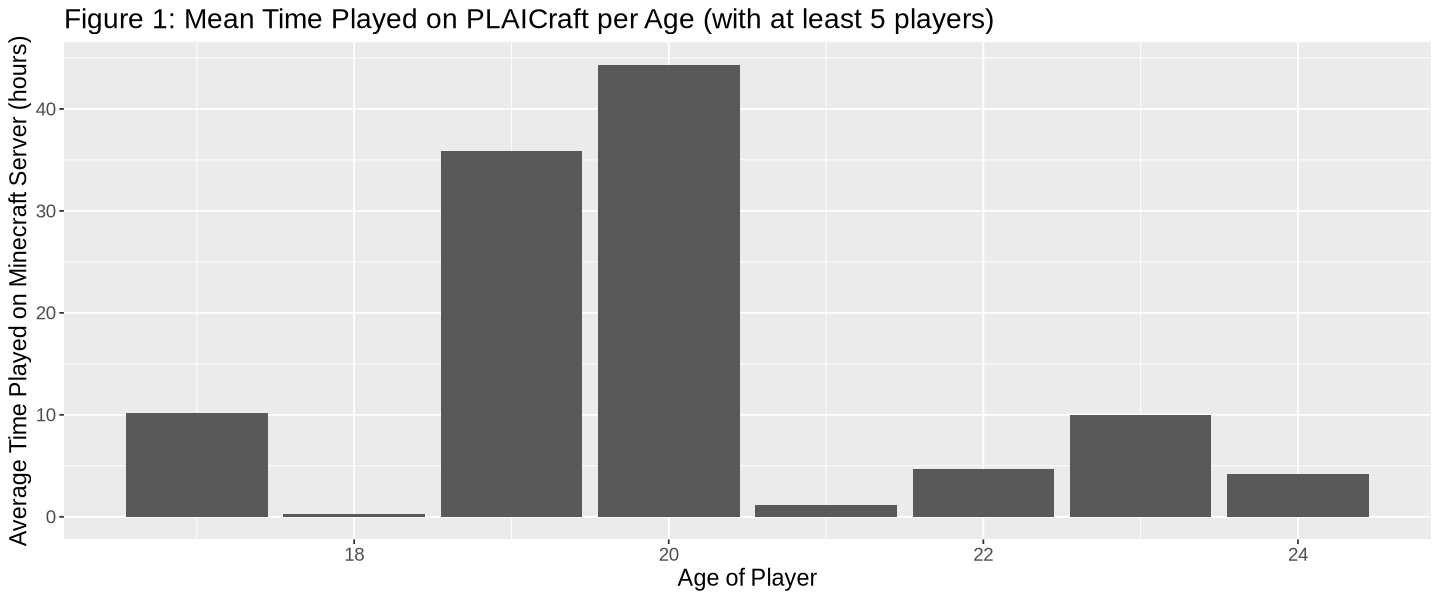

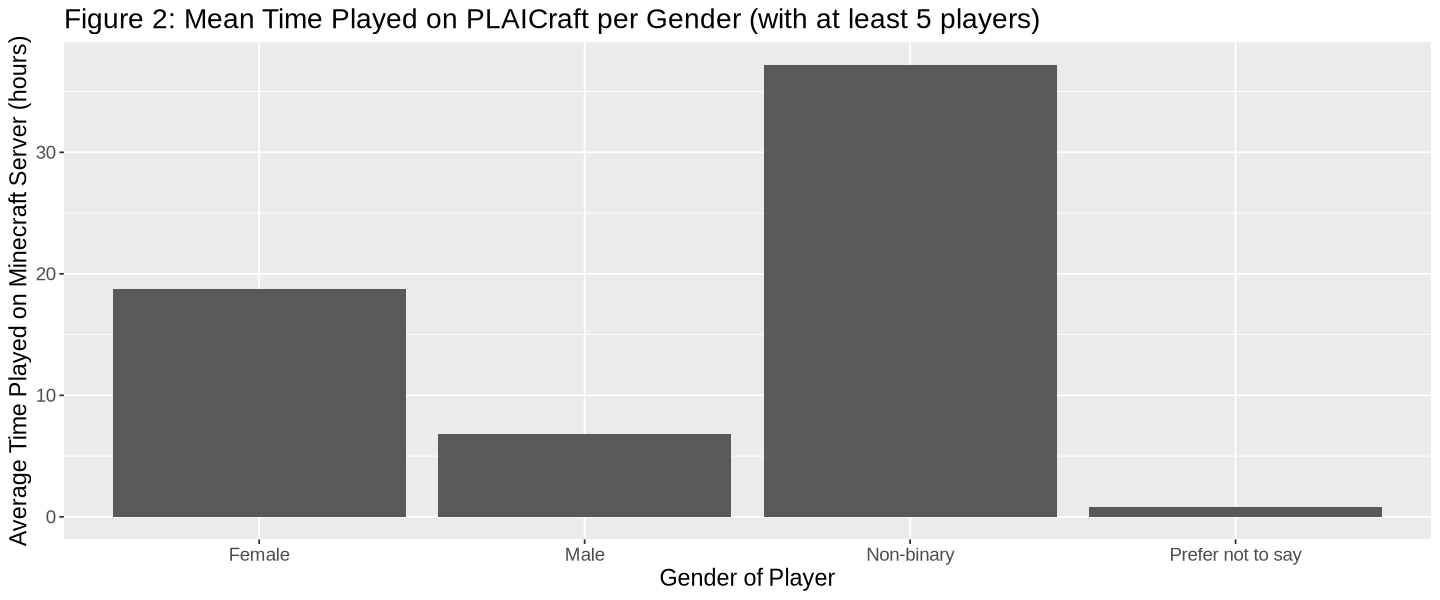

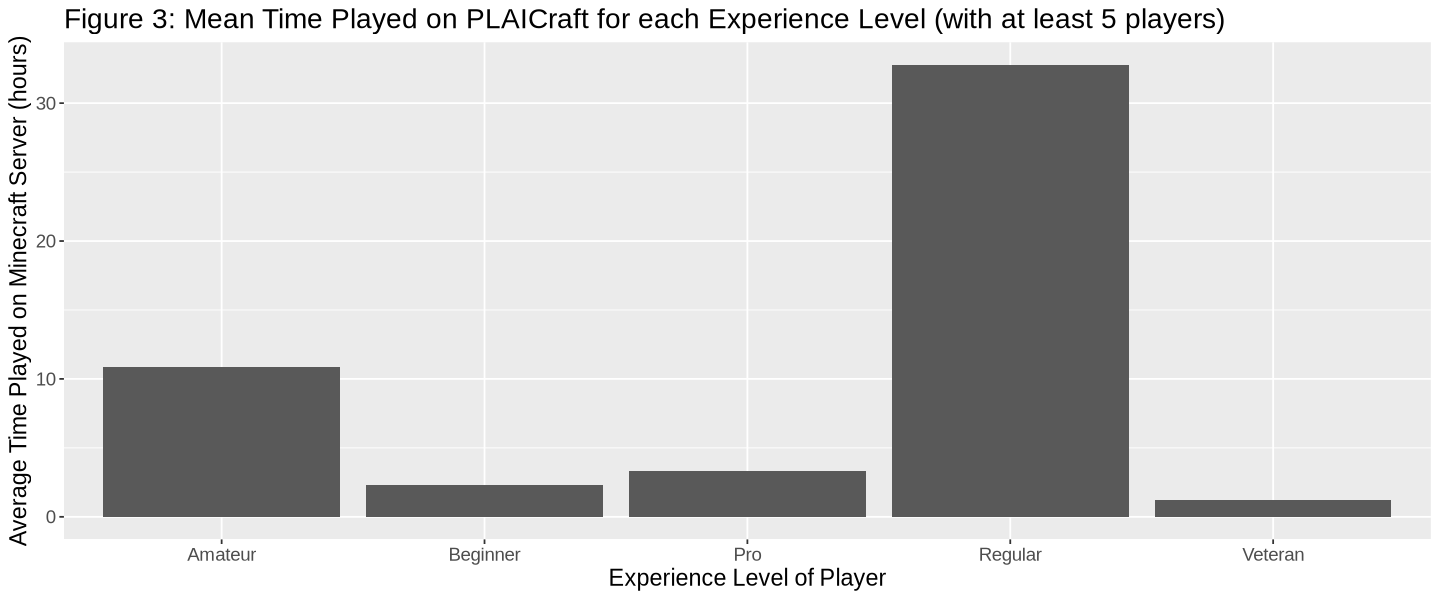

In [13]:
options(repr.plot.width = 12, repr.plot.height = 5)
# Setup data for each plot. We filter so that the number of data points per category is at least 5 to reduce noise since a dataset with less than 5 is 
# not enough to generalize for the whole population

age_avg_data = clean_player_data |>
    filter(played_hours > 0) |>
    group_by(age) |>
    summarize(mean = mean(played_hours), median = median(played_hours), count = n()) |>
    filter(count >= 5) 

gender_avg_data = clean_player_data |>
    filter(played_hours > 0) |>
    group_by(gender) |>
    summarize(mean = mean(played_hours), median = median(played_hours), count = n()) |>
    filter(count >= 5)

experience_avg_data = clean_player_data |>
    filter(played_hours > 0) |>
    group_by(experience) |>
    summarize(mean = mean(played_hours), median = median(played_hours), count = n()) |>
    filter(count >= 5)

# Plot setup
mean_age_plot <- age_avg_data |>
    ggplot(aes(x = age, y = mean)) +
    geom_bar(stat = "identity") +
    labs(x = "Age of Player", y = "Average Time Played on Minecraft Server (hours)") +
    ggtitle("Figure 1: Mean Time Played on PLAICraft per Age (with at least 5 players)") +
    theme(text = element_text(size = 14))

mean_age_plot


mean_gender_plot <- gender_avg_data |>
    ggplot(aes(x = gender, y = mean)) +
    geom_bar(stat = "identity") + 
    labs(x = "Gender of Player", y = "Average Time Played on Minecraft Server (hours)") +
    ggtitle("Figure 2: Mean Time Played on PLAICraft per Gender (with at least 5 players)") +
    theme(text = element_text(size = 14))
mean_gender_plot


mean_xp_plot <- experience_avg_data |>
    ggplot(aes(x = experience, y = mean)) +
    geom_bar(stat = "identity") + 
    labs(x = "Experience Level of Player", y = "Average Time Played on Minecraft Server (hours)") +
    ggtitle("Figure 3: Mean Time Played on PLAICraft for each Experience Level (with at least 5 players)") +
    theme(text = element_text(size = 14))

mean_xp_plot

By observation of the mean averages, we can see that players who are 19-20, female or non-binary, and of regular or amateur Minecraft experience have outstanding playing times. Now observing the median values:

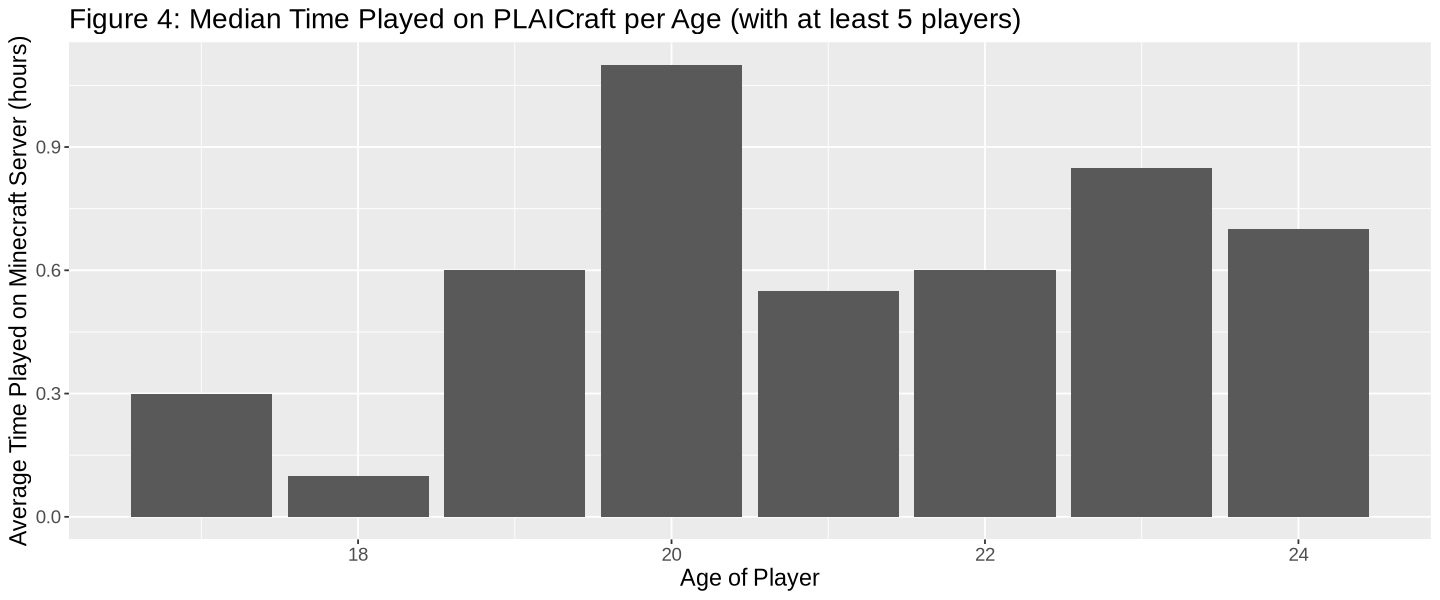

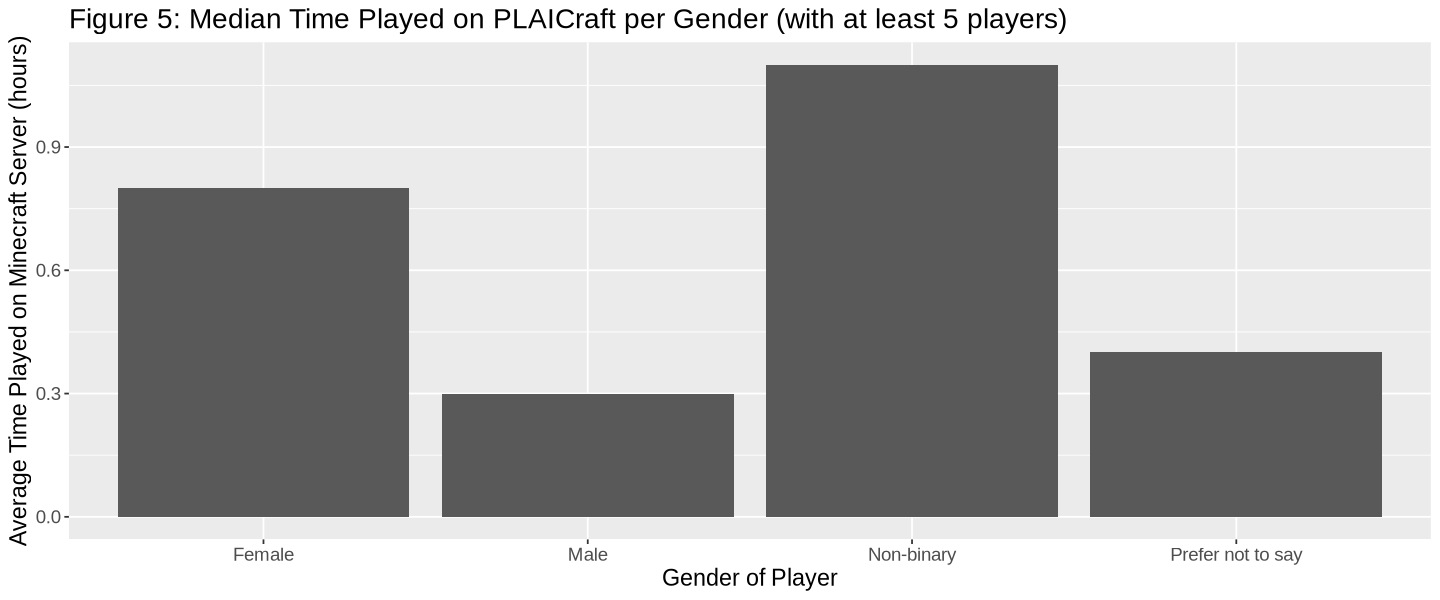

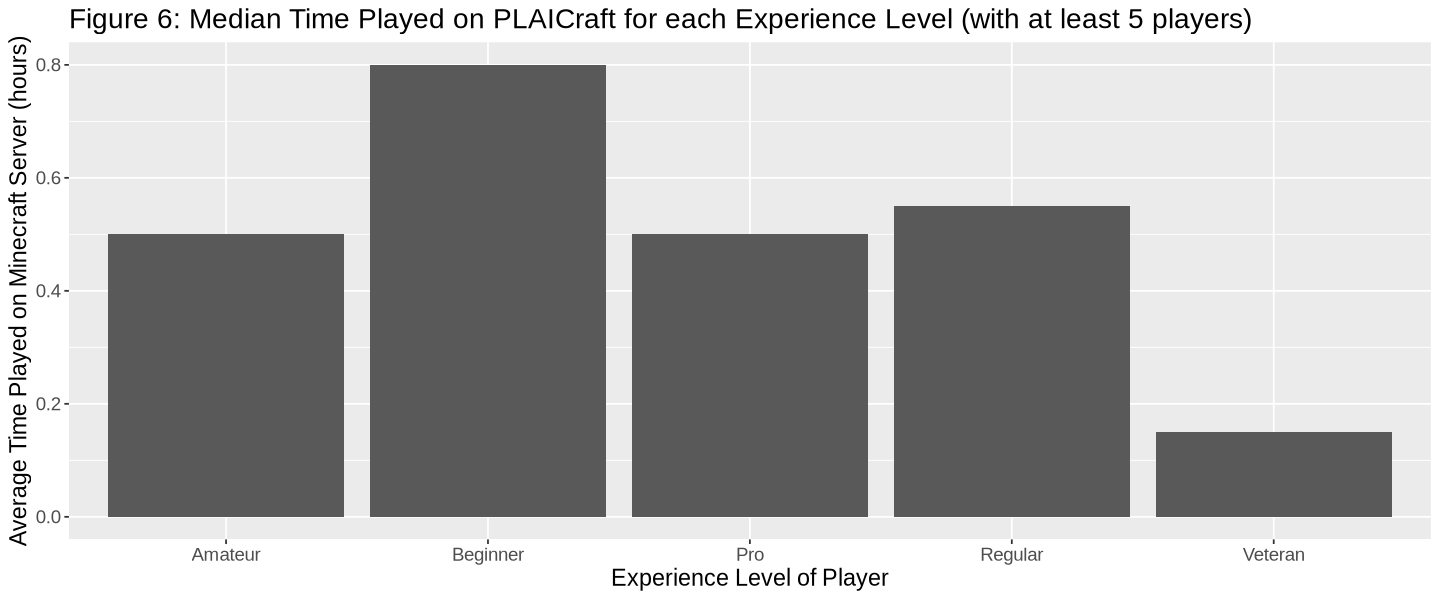

In [14]:
options(repr.plot.width = 12, repr.plot.height = 5)
median_age_plot <- age_avg_data |>
    ggplot(aes(x = age, y = median)) +
    geom_bar(stat = "identity") +
    labs(x = "Age of Player", y = "Average Time Played on Minecraft Server (hours)") +
    ggtitle("Figure 4: Median Time Played on PLAICraft per Age (with at least 5 players)") +
    theme(text = element_text(size = 14))

median_age_plot


median_gender_plot <- gender_avg_data |>
    ggplot(aes(x = gender, y = median)) +
    geom_bar(stat = "identity") + 
    labs(x = "Gender of Player", y = "Average Time Played on Minecraft Server (hours)") +
    ggtitle("Figure 5: Median Time Played on PLAICraft per Gender (with at least 5 players)") +
    theme(text = element_text(size = 14))

median_gender_plot


median_xp_plot <- experience_avg_data |>
    ggplot(aes(x = experience, y = median)) +
    geom_bar(stat = "identity") + 
    labs(x = "Experience Level of Player", y = "Average Time Played on Minecraft Server (hours)") +
    ggtitle("Figure 6: Median Time Played on PLAICraft for each Experience Level (with at least 5 players)") +
    theme(text = element_text(size = 14))

median_xp_plot

The above graphs show that the median for each category is much less than the mean. This suggests that the data is either very positively skewed or contains many outliers that have large hours contributions (compared to the rest). Looking at the median graphs, each category differs by less than a fraction of an hour, while the mean differs by multiple hours. We can conclude that the data is generally dense (excluding the outliers) since the scale of our played_hours is much larger relative to the difference in the median played_hours. The median being under 1 hour for almost every statistic also tells us that many people are not playing. <br>
<br>
After looking at both our mean and median graphs, we can hypothesize that the knn algorithm might suffer in accuracy in two ways. One is that the algorithm might fail to predict extreme outliers in our testing set since the majority of the data is very dense. Another reason is that we have multiple categories within our variables with high variability (in regards to played_hours) since many people have spent little time on the server regardless of their age, gender, or prior experience. This means that their actual playing time will be close to 0 regardless.

### **Analysis**

We will be creating a knn regression predictive model and in order to do that we first need to split our data into training data and testing data. We are creating a split of 75% training data and 25% testing data.

In [6]:
# Setting seed to make our analysis reproducible
set.seed(1234)

data_split <- initial_split(clean_player_data, prop = 0.75, strata = played_hours)
data_training <- training(data_split)
data_testing <- testing(data_split)

Next we'll create a recipe for our training data where we are specifying played_hours as our response variable, and experience, age, and gender as our predictors. In the recipe we are both converting our categorical variables into numerical values (via step_dummy()) and standardizing our predictors.

In [7]:
predict_recipe <- recipe(played_hours ~ experience + gender + age, data = data_training) |>
        step_dummy(experience, gender) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

Since we will be using knn regression for our predictive model, we first have to perform cross validation to determine the best k value. So here we are creating a tuning specification for our knn regression and combining our recipe and model specification into a workflow that we can then use for cross validation. We will be performing a 5-fold cross validation for k values ranging from 1 to 100, so we are also setting up that as well.

In [8]:
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

tuning_workflow <- workflow() |>
                    add_recipe(predict_recipe) |>
                    add_model(tuning_spec)

# Setup folds & k values for folds
data_vfold <- vfold_cv(data_training, v = 5, strata = played_hours)
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

We are now determining the k value that minimizes the RMSE. To do this, we use our workflow from before and tune it by testing the range of k values on our 5-fold cross validation dataset. We then are collecting the metrics from our model and identifying which k value is associated with the lowest RMSE.

In [9]:
tuning_results <- tuning_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1) |>
    select(neighbors)
tuning_results

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors
<dbl>
74


From the previous code block we identified that the best k value is k = 74. Thus, with that we are now creating the knn regression specification for our predictive model. We then are using that specification and our recipe from before to create a fitted model that has been trained on our training data.

In [10]:
predict_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 74) |> 
      set_engine("kknn") |>
      set_mode("regression") 

predict_fit <- workflow() |>
                add_recipe(predict_recipe) |>
                add_model(predict_spec) |>
                fit(data_training)

We are now calculating predicted values for our test data using our fitted predictive model.

In [11]:
predict_table <- predict_fit |>
                    predict(data_testing) |>
                    bind_cols(data_testing)

Here we are now analyzing the quality of our regression model. We are using the metrics function to compute the RMSPE of our regression. We are also creating some visualizations to further evaluate the quality of our predictive model. We are creating a scatterplot that compares the observed played hours to the predicted played hours and a residual plot that shows the differences between predicted played hours and observed played hours.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.54369


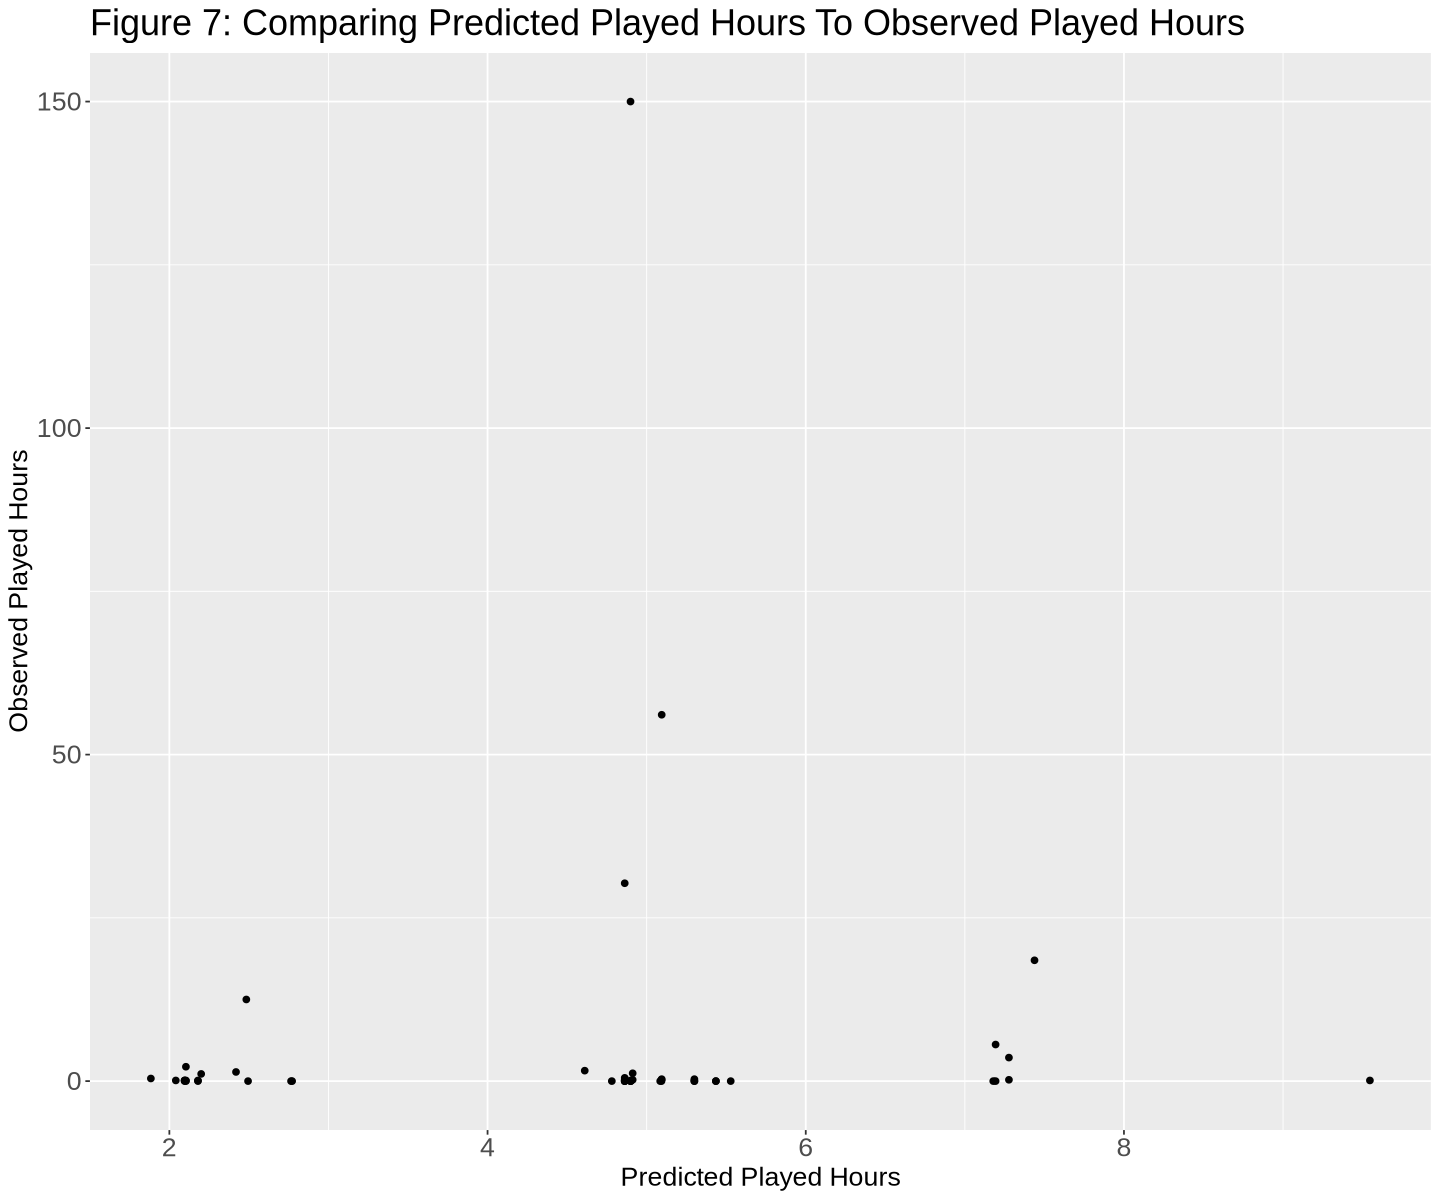

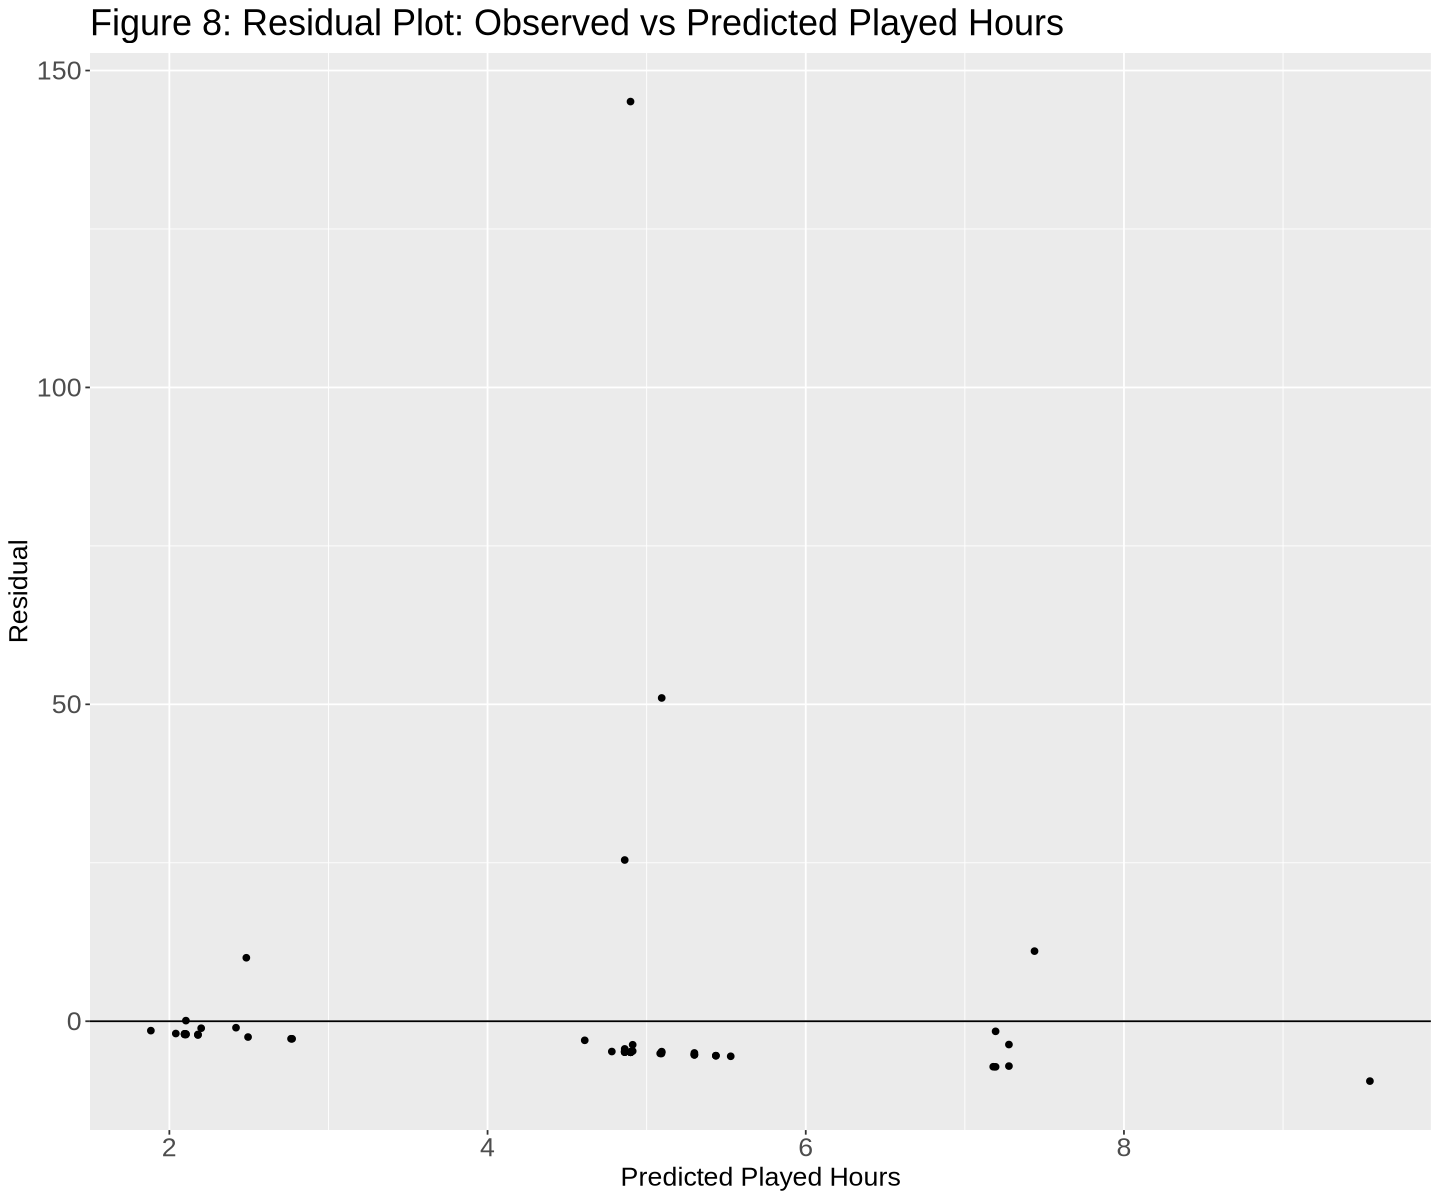

In [12]:
predict_metrics <- predict_table |> 
                metrics(truth = played_hours, estimate = .pred) |> 
                filter(.metric == "rmse")
predict_metrics
                             
options(repr.plot.width = 12, repr.plot.height = 10)
predict_vs_observed <- ggplot(predict_table, aes(x = .pred, y = played_hours)) +
    geom_point() +
    labs(x = "Predicted Played Hours", y = "Observed Played Hours", title = "Figure 7: Comparing Predicted Played Hours To Observed Played Hours") +
    theme(text = element_text(size = 18), axis.title = element_text(size = 16), axis.text = element_text(size = 16))
predict_vs_observed

# Create a table to analyze the residuals between predicted and observed played hours
residuals <- predict_table |> mutate(residual = played_hours - .pred) |> select(.pred, residual)

residual_plot <- ggplot(residuals, aes(x = .pred, y = residual)) +
    geom_point() +
    geom_hline(aes(yintercept = 0)) + 
    labs(x = "Predicted Played Hours", y = "Residual", title = "Figure 8: Residual Plot: Observed vs Predicted Played Hours") +
    theme(text = element_text(size = 18), axis.title = element_text(size = 16), axis.text = element_text(size = 16))
residual_plot

## **Discussion**

Through the distribution of the data from the PlaiCraft server was observed that players who belonged to the female or non-binary gendered category, ages 19-20 and who identify as amateur or regular (in Minecraft experience) were observed to have the most play time on the server. On the contrary, when observing the medians of the same groups, it was observed that each category (categories from experience level, gender and age) had a median of less than an hour. This imposes a big threat to the accuracy of our KNN regression model as the inconsistencies of our mean and median can be interpreted as the distribution of our population has a positive skew (most of the points are centralized in a low range, with extreme outliers in the high range). There is a small demographic in our data that is contributing the most hours to our PLAIcraft server, whereas the majority of the population is contributing very little. These outliers hurt our predictive model as the algorithm will fail to properly handle extreme outliers and the variability of our data will lead to inaccurate predictions or low test scores. We have chosen to use k=74 in our KNN algorithm, as given our training data, it was the k value that held the least root mean squared error (least average error in hours on the predictions). Based on our model, it seems that the predictors that we have chosen are not good at predicting total hours played. As seen from the visualizations of our residuals plot (Figure 2), it seems that our residuals are clustered which may be because of some unknown relationship that we are not accounting for. The presence of the extreme outlier may make it hard to generalize results for our predicted variable, also introducing un

The age group of our findings were not much of a surprise as people in the 19-20 year old age group grew up playing Minecraft in their childhoods, as Minecraft is highest grossing game ever, so the experience to Minecraft cannot be denied. But the gender group and experience levels were surprising, as you would believe that people who know more about the game would want to play but the data said otherwise, that people that know less about the game want to play more. Gaming is not a thing that is normally targeted towards the female gender, so the data saying that females and non-binary-gendered people tended to play more was a surprise.


With our findings companies are able to see which types of people are most likely to be playing Minecraft when given the opportunity. With our data, companies can choose to further expand their target demographic by appealing to a wider range of audience or to hone in on their current demographic and to focus on appealing to them more.

Looking at session data maybe the best measurment of time commitment, but the research team would need to evaluate if they value total hours given or if they care more if a person gives more hours in one play session than over multiple sessions. You could also collect more data such as the activites of each player (e.g., how many blocks they break, how many blocks they put down, which blocks they are placing) to further develop a better understanding of what people are doing within the game that makes them play more hours. By keeping track of this, future research could look into what people are doing that makes them spend so much time on the game. Not looking at target demographics and who is giving most of their time, but now evaluate gameplay, and ask what is making these players have fun and spend so many hours?

We are not able to come to any conclusions based on our data and predictive model, the choice of predictors doesn't seem to predict total hours played very well because of the existence of skewed distributions, and extreme outliers.